# **Introduction**

This project analyzes a **water quality dataset** to predict potability (whether water is safe to drink). It contains 3276 entries with 10 variables, including pH, hardness, solids, chloramines, sulfate, conductivity, organic carbon, trihalomethanes, turbidity, and potability (target variable: 1 for drinkable, 0 for not drinkable). Some variables have missing values, which will be addressed during preprocessing. The project focuses on data cleaning, exploratory analysis, and model building to **predict water potability** based on these features.


**Importing modules:**

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Scikit-learn modules
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)

#**Dataset Overview**

In [32]:
df = pd.read_csv('water_potability.csv')
print(df.head())
print(df.info())

         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  -

Each plot represents one chemical feature from the dataset. Features with **non-overlapping blue and red distributions** will likely be **more informative for predicting potability**.

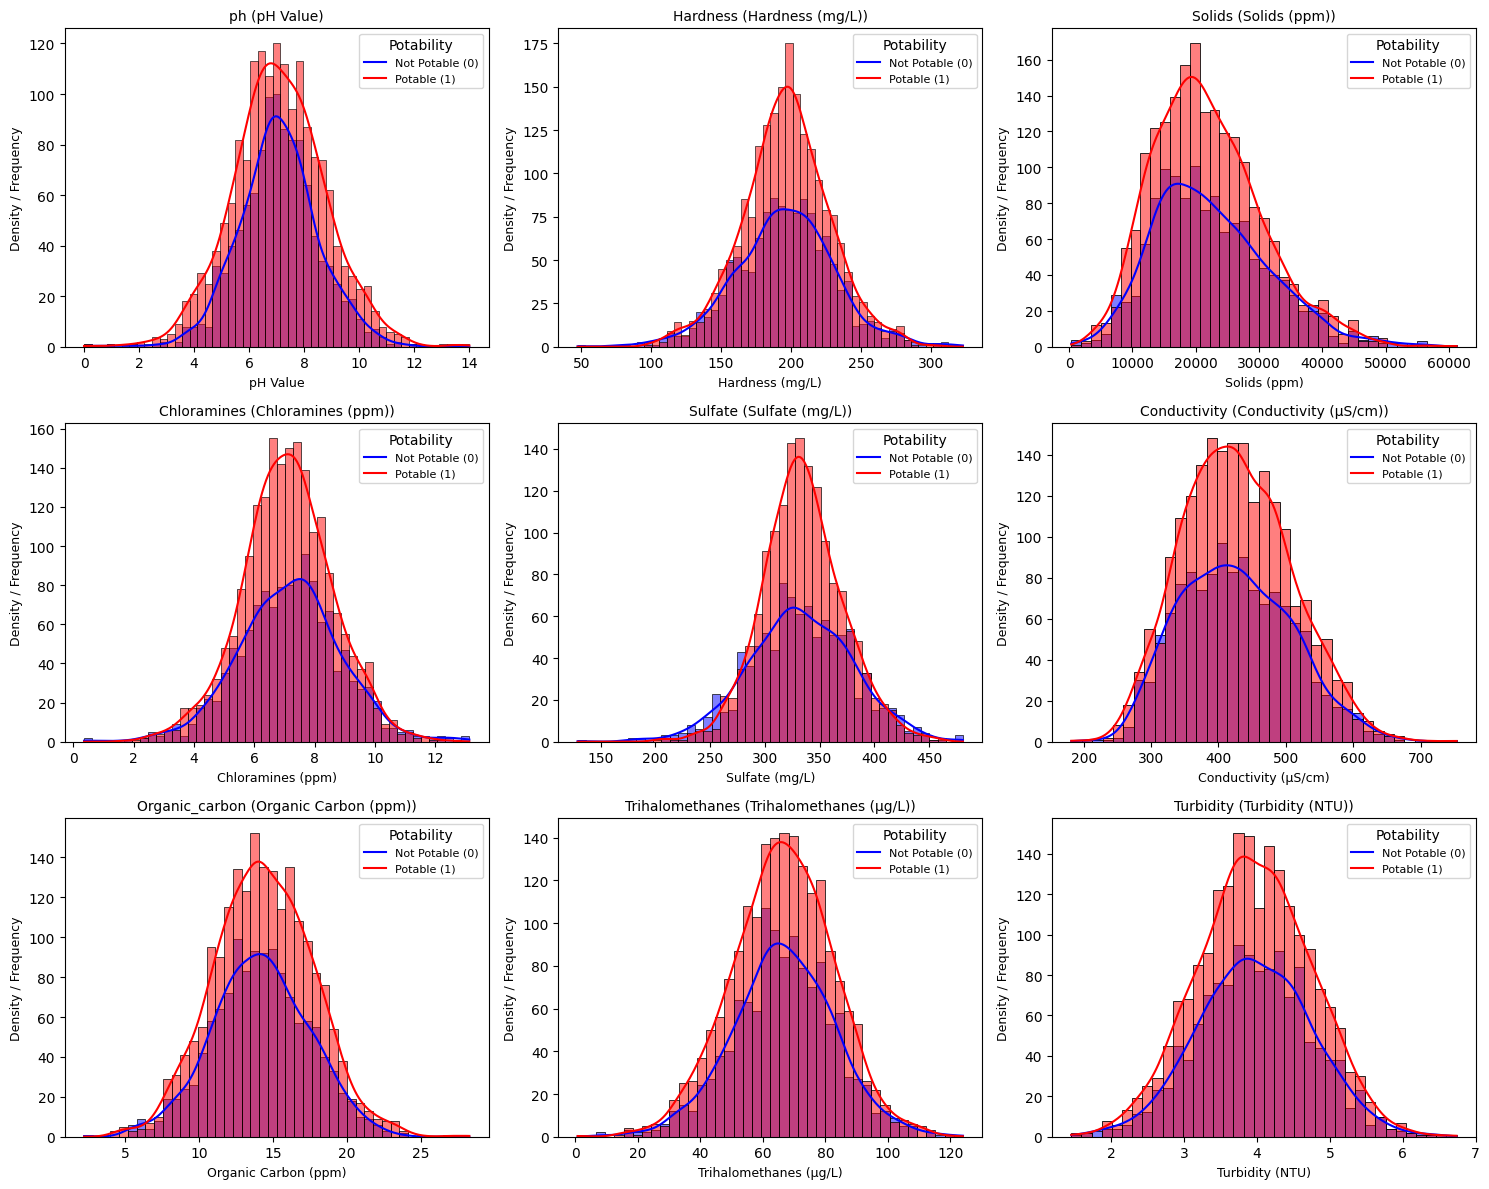

In [33]:
features_units = {
    'ph': 'pH Value',
    'Hardness': 'Hardness (mg/L)',
    'Solids': 'Solids (ppm)',
    'Chloramines': 'Chloramines (ppm)',
    'Sulfate': 'Sulfate (mg/L)',
    'Conductivity': 'Conductivity (μS/cm)',
    'Organic_carbon': 'Organic Carbon (ppm)',
    'Trihalomethanes': 'Trihalomethanes (μg/L)',
    'Turbidity': 'Turbidity (NTU)'
}

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, (feature, unit) in enumerate(features_units.items()):
    sns.histplot(data=df, x=feature, hue='Potability', kde=True,
                 palette={0: "red", 1: "blue"}, alpha=0.5, ax=axes[idx])
    axes[idx].set_title(f'{feature} ({unit})', fontsize=10)
    axes[idx].set_xlabel(unit, fontsize=9)
    axes[idx].set_ylabel('Density / Frequency', fontsize=9)
    axes[idx].legend(title='Potability', labels=['Not Potable (0)', 'Potable (1)'], fontsize=8)

plt.tight_layout()
plt.show()

# **Handling missing values**

Logistic regression and Random Forest cannot process missing values directly as they require complete datasets to train effectively. Therefore, in order to reduce bias in analysis and make the model more reliable missing values will be checked in this dataset.

**Missing Data**:

*   **ph** has 2785 non-null values out of 3276 entries.
*   **Sulfate** has 2495 non-null values.
*   **Trihalomethanes** has 3114 non-null values.
*   Other columns have no missing values

In [34]:
# Checking for missing data
print(df.isnull().sum())

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


**ph:**
*   The mean pH (~7.08) is around neutral, as expected for drinking water.
*   The presence of a **minimum value of 0 suggests** errors or outliers that should be investigated further.


**sulfate:**
*   The sulfate concentration values are reasonable, with most data concentrated around the mean (~333 mg/L).
*   The relatively high IQR (307.7–359.95) indicates some variability, but the range is within expected drinking water standards.

**trihalomethanes:**
*   These values are consistent with water treatment processes. The mean (66.4 µg/L) and range are within safe drinking water limits in many regions.

In [35]:
# Obtaining information on columns with missing values
print(df['ph'].describe())
print(df['Sulfate'].describe())
print(df['Trihalomethanes'].describe())

count    2785.000000
mean        7.080795
std         1.594320
min         0.000000
25%         6.093092
50%         7.036752
75%         8.062066
max        14.000000
Name: ph, dtype: float64
count    2495.000000
mean      333.775777
std        41.416840
min       129.000000
25%       307.699498
50%       333.073546
75%       359.950170
max       481.030642
Name: Sulfate, dtype: float64
count    3114.000000
mean       66.396293
std        16.175008
min         0.738000
25%        55.844536
50%        66.622485
75%        77.337473
max       124.000000
Name: Trihalomethanes, dtype: float64


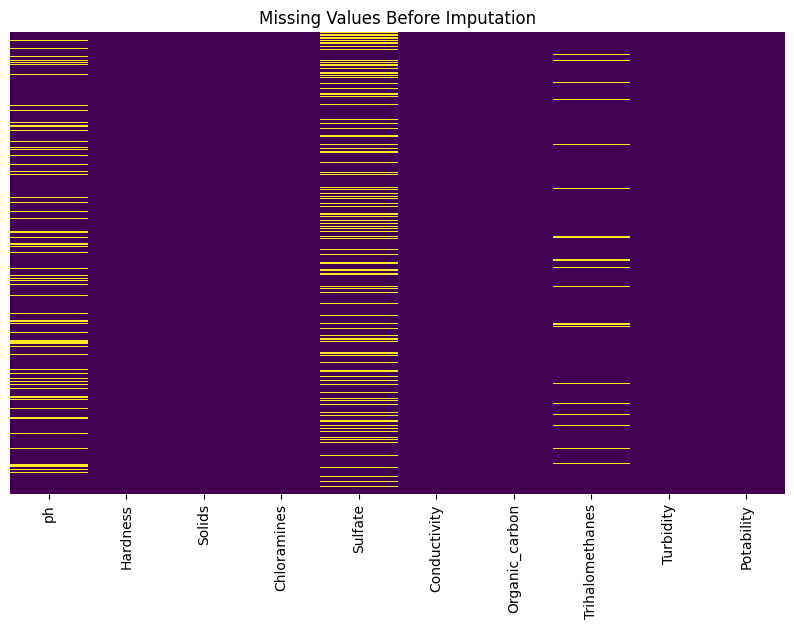

In [36]:
# Visualising missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Before Imputation')
plt.show()

# **Replacing Missing values**

**ph:**
*   Has skewed distribution due to extreme min value of 0.
*   **Median** will be used

**Sulfate:**
*   symmetrical distribution, **Mean** will be used

**Trihalomethanes:**
*   symmetrical disgribution, **Mean** will be used


In [37]:
# Filling missing values
df['ph'] = df['ph'].fillna(df['ph'].median())
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].mean())
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].mean())

print(df.isnull().sum())

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


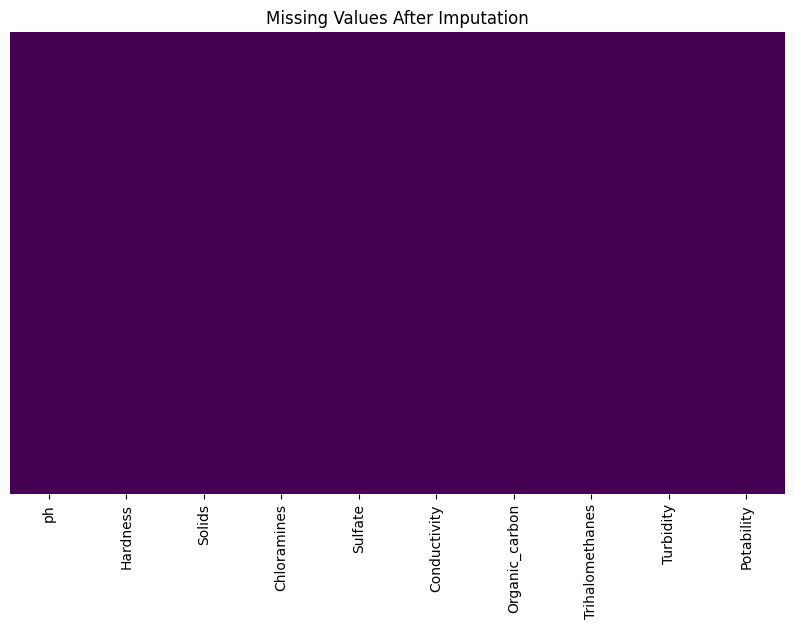

In [38]:
# Visualising missing values after imputation
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values After Imputation')
plt.show()

# **Exploratory Data Analysis**

**Shape of Distributions**: Checking whether the variables are normally distributed, skewed, or have outliers.

*   Most features have **sheweness values close to 0**, indicating that they are relatively symmetrical.
*   **Solids (0.621)** show **mild skeweness** but not extreme


In [39]:
# Calculating skewness for each numerical column
skewness = df.skew()
print("Skewness of numerical features:")
print(skewness)

Skewness of numerical features:
ph                 0.041266
Hardness          -0.039342
Solids             0.621634
Chloramines       -0.012098
Sulfate           -0.041184
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.085161
Turbidity         -0.007817
Potability         0.450784
dtype: float64


The skewness of 'Solids' (0.621) indicates a **mild right skew**, with more values concentrated toward the lower range and a longer tail extending to the right. However, this is **not extreme**, thus **no adjustments** to this feature.

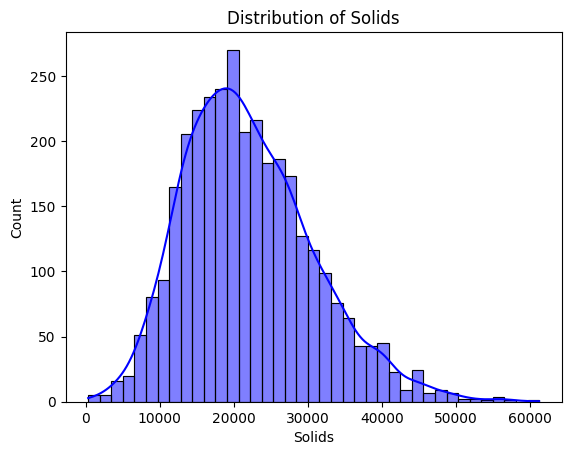

In [40]:
# Skeweness of Solids
sns.histplot(df['Solids'], kde=True, color='blue')
plt.title("Distribution of Solids")
plt.show()

**Correlation between Variables**: enables identification of the most important featurs for the model.

*   Dark red represents strong positive correlations, while dark blue represents strong negative correlations
*   Features with weak correlations to the target variable might not add predictive value and could be excluded

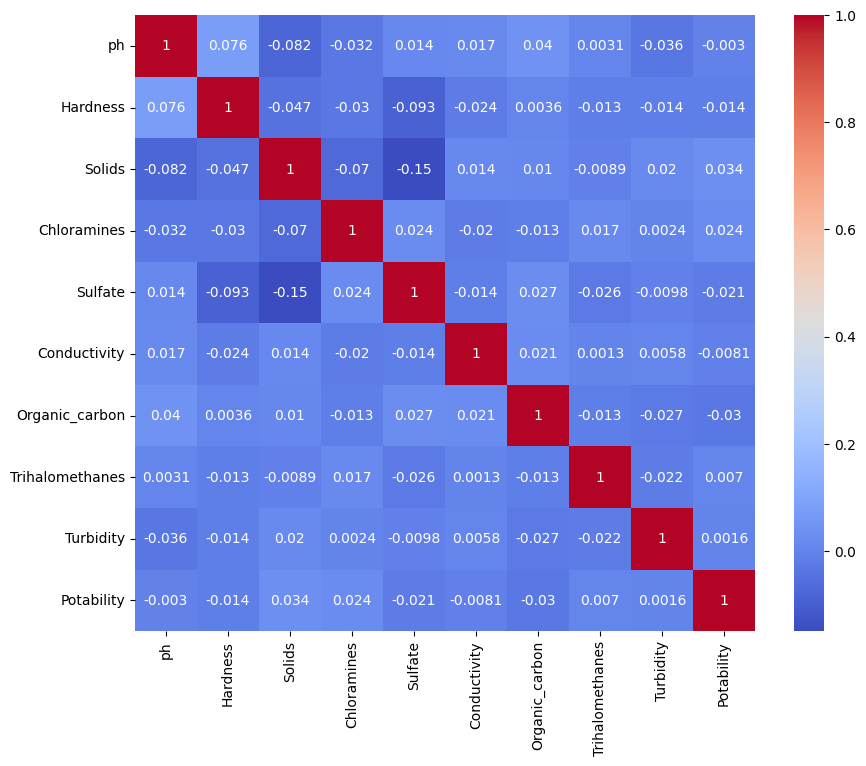

In [41]:
# Plotting correlation matrix to examine the relationship between features
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# **Class Imbalance**

Potability distribution with **~39% potable and ~61% not potable** is considered moderately imbalanced. Accuracy might not be a good measure of performance in this case, as high accuracy could just be from predicting the majority class. Instead, focus will be on metrics like **Precision, Recall, F1-Score, and the ROC-AUC curve**.

<ipython-input-42-c0cbf7c0b555>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Potability', data=df, palette='Set2')


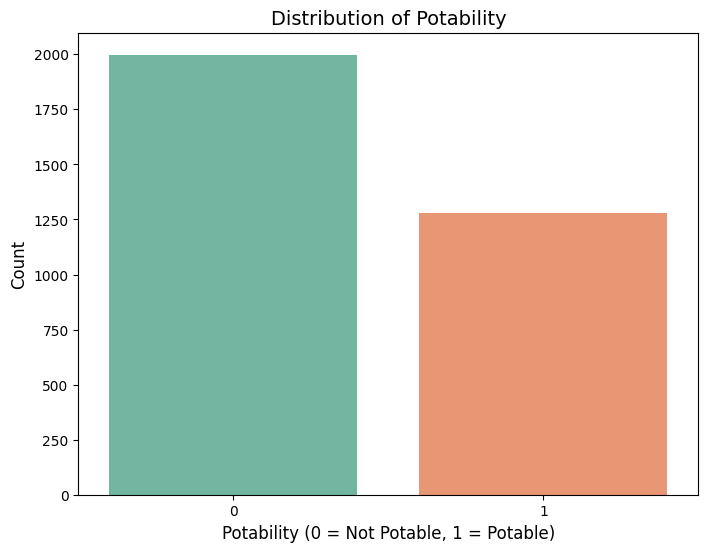

In [42]:
# Visualising the distribution of the target variable 'Potability'
plt.figure(figsize=(8, 6))
sns.countplot(x='Potability', data=df, palette='Set2')

plt.title('Distribution of Potability', fontsize=14)
plt.xlabel('Potability (0 = Not Potable, 1 = Potable)', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

# **Model Development - Logistic Regression**

Features (x) will be separated from the target variable (y) and split into training and testing sets.

In [43]:
x = df.drop('Potability', axis=1)
y = df['Potability']

# Splitting into training and testing sets (80% train, 20% test) with stratification to maintain target proportion
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

print("x_train => ",x_train.shape)
print("x_test => ", x_test.shape)
print("y_train => ", y_train.shape)
print("y_test => ", y_test.shape)


x_train =>  (2620, 9)
x_test =>  (656, 9)
y_train =>  (2620,)
y_test =>  (656,)


**Min-Max Normalization** scales the data to a range [0, 1].

In [44]:
x_train_max = np.max(x_train)
x_train_min = np.min(x_train)
x_train = (x_train - x_train_min) / (x_train_max - x_train_min)
x_test = (x_test - x_train_min) / (x_train_max - x_train_min)

**Underrepresented class potable ~39%** will be given **higher weight**.

Accuracy: 0.5350609756097561

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.56      0.60       400
           1       0.42      0.49      0.45       256

    accuracy                           0.54       656
   macro avg       0.53      0.53      0.52       656
weighted avg       0.55      0.54      0.54       656



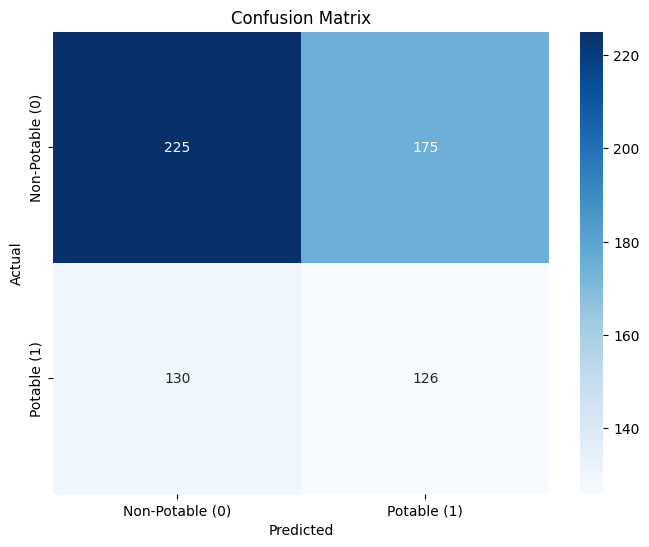

Training set size: 2620 samples
Test set size: 656 samples


In [46]:
# Initialising Logistic Regression with balanced class weight and increased max_iter
model = LogisticRegression(class_weight='balanced', max_iter=500)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Potable (0)', 'Potable (1)'], yticklabels=['Non-Potable (0)', 'Potable (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Training set size: " + str(len(x_train)) + " samples")
print("Test set size: " + str(len(x_test)) + " samples")

# **Feature Selection**

**Mutual information** shows dependency between each feature and the target variable:
- **Hardness ans Sulfate** have the **highest dependency with the target** (~0.02), but still relatively low


In [47]:
# Computing mutual information between each feature and the target
mutual_info = mutual_info_classif(x_train, y_train)

mi_df = pd.DataFrame({'Feature': x.columns, 'Mutual Information': mutual_info})
print(mi_df.sort_values(by='Mutual Information', ascending=False))

           Feature  Mutual Information
1         Hardness            0.022567
4          Sulfate            0.010091
5     Conductivity            0.007439
6   Organic_carbon            0.007346
0               ph            0.006569
8        Turbidity            0.002908
2           Solids            0.000000
3      Chloramines            0.000000
7  Trihalomethanes            0.000000


ANOVA F-test selects features that have the most significant relationship with the target variable (Potability).

**From the ANOVA F-test, the selected features are:**
- ph
- Solids
- Chloramines
- Sulfate
- Organic_carbon


In [48]:
# Selecting the top 5 features based on the F-test
selector = SelectKBest(f_classif, k=5)
x_new = selector.fit_transform(x_train, y_train)

selected_features = x.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['ph', 'Solids', 'Chloramines', 'Sulfate', 'Organic_carbon'], dtype='object')


**Retraining model by focusing on the most informative features** based on the ANOVA F-test selected features. After applying feature selection performance **did not improve significantly**.

Accuracy: 0.538109756097561

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.54      0.59       400
           1       0.43      0.54      0.48       256

    accuracy                           0.54       656
   macro avg       0.54      0.54      0.53       656
weighted avg       0.56      0.54      0.54       656



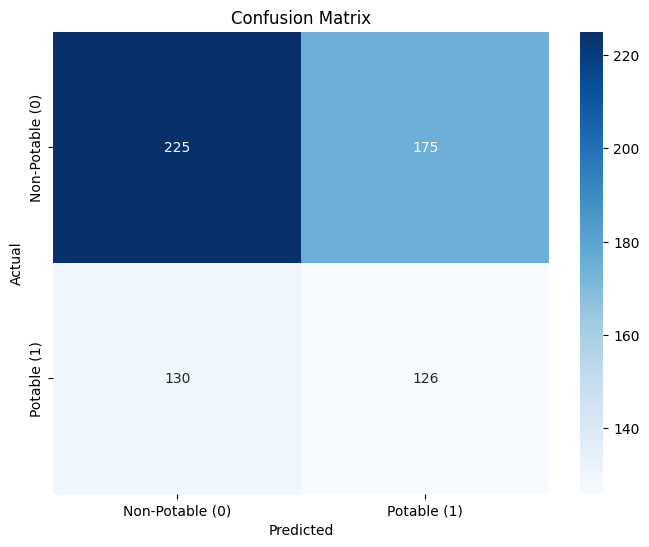

Training set size: 2620 samples
Test set size: 656 samples


In [49]:
x_selected = x[selected_features]

x_train_selected, x_test_selected, y_train, y_test = train_test_split(x_selected, y, test_size=0.2, random_state=42, stratify=y)

# Fitting with selected features
model.fit(x_train_selected, y_train)

y_pred = model.predict(x_test_selected)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Potable (0)', 'Potable (1)'], yticklabels=['Non-Potable (0)', 'Potable (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Training set size: " + str(len(x_train_selected)) + " samples")
print("Test set size: " + str(len(x_test_selected)) + " samples")

Even after feature selection the results futher support the idea that logictic regression may not be capturing the complexity of the data which is also proved by 5 fold splits.

In [50]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
model = LogisticRegression(class_weight='balanced', max_iter=500)
cv_scores = cross_val_score(model, x_selected, y, cv=cv, scoring='accuracy')
print("Cross-validated Accuracy Scores:", cv_scores)

Cross-validated Accuracy Scores: [0.51981707 0.54503817 0.50992366 0.51603053 0.49923664]


#**Model Development - Random Forest**

**Random forest** performs better than logistic regression in predicting 'Not Potable' but underperforms in underrepresented 'Potable' class.


Random Forest Accuracy: 0.6646341463414634

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.88      0.76       400
           1       0.64      0.33      0.43       256

    accuracy                           0.66       656
   macro avg       0.65      0.60      0.60       656
weighted avg       0.66      0.66      0.63       656


Confusion Matrix:
 [[352  48]
 [172  84]]


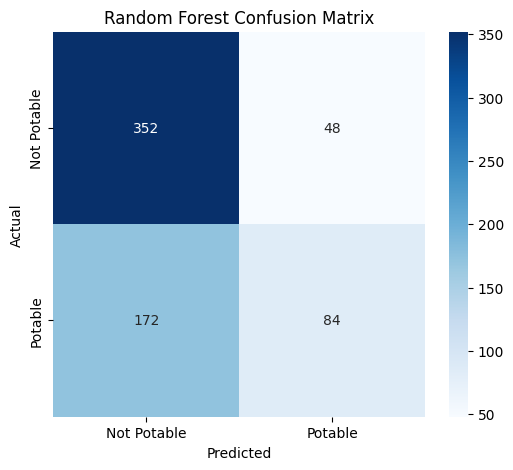

Training set size: 2620 samples
Test set size: 656 samples


In [52]:
# Initialising Random Forest Classifier with selected features

model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

model_rf.fit(x_train_selected, y_train)

y_pred_rf = model_rf.predict(x_test_selected)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:\n", conf_matrix_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Potable', 'Potable'], yticklabels=['Not Potable', 'Potable'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("Training set size: " + str(len(x_train_selected)) + " samples")
print("Test set size: " + str(len(x_test_selected)) + " samples")


# **Hyperparameter Tuning with GridSearchCV**

The GridSearchCV is using the **RandomForestClassifier (model_rf) as the base model** and tries all the combinations of hyperparameters defined in the param_grid to evaluate the model performance using cross-validation. The search uses the **f1 score** to evaluate the models.

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Accuracy: 0.6631

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.81      0.75       400
           1       0.59      0.43      0.50       256

    accuracy                           0.66       656
   macro avg       0.64      0.62      0.62       656
weighted avg       0.65      0.66      0.65       656


Confusion Matrix:
 [[325  75]
 [146 110]]


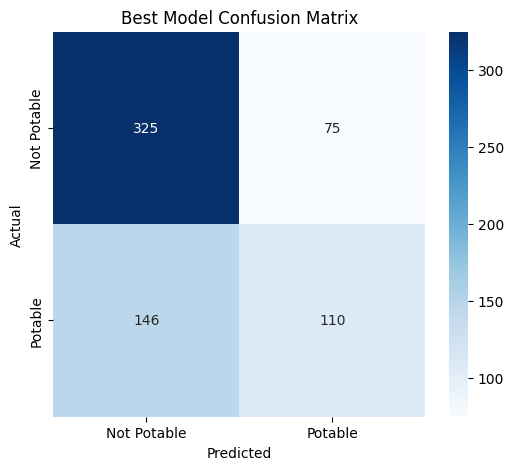

In [53]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced'],
}

grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1')
grid_search.fit(x_train_selected, y_train)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(x_test_selected)

accuracy = accuracy_score(y_test, y_pred_best)
print("Accuracy: " + str(round(accuracy, 4)))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

conf_matrix_rf = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:\n", conf_matrix_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Potable', 'Potable'], yticklabels=['Not Potable', 'Potable'])
plt.title('Best Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **ROC Curve and AUC**

This is the ROC curve of selected model is stored in **best_model as compared to the random classifier**. An AUC of **0.6832** is a **moderate ability** to distinguish between the two classes ("Not Potable" and "Potable"). It's **better than random guessing** (which would give an AUC of 0.5), but **there's still room for improvement**.  

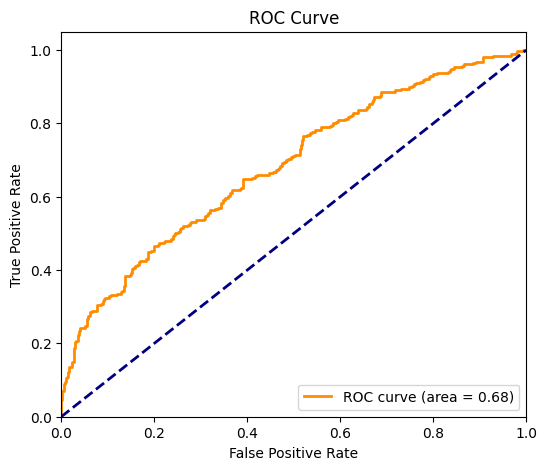

AUC: 0.6832


In [54]:
y_prob_best = best_model.predict_proba(x_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC: " + str(round(roc_auc, 4)))

# **Model Comparison**

- Based on the performance, **logistic regression is underperforming**, likely due to its assumptions about linearity between features and outcomes, which might not hold for this dataset.
- While **Random Forest has the highest accuracy**, it still does not show a perfect result. However, accuracy alone is not sufficient, especially when the dataset is imbalanced (with potable water being a minority class).
- While both models including Random Forest are better at identifying class 0 (non-potable), they are not as good at identifying class 1 (potable), which is the main challenge here for water potability prediction.

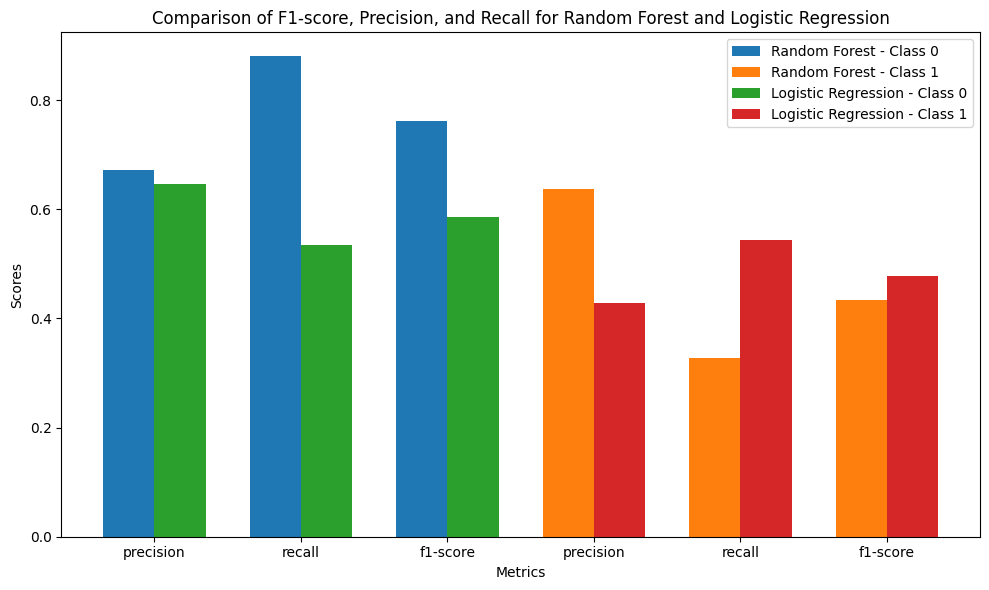

In [56]:
# Plotting final Logistic Regression and Random Forest values for comparison
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_logistic = classification_report(y_test, y_pred, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
models = ['Random Forest', 'Logistic Regression']

metric_values_rf = [report_rf['0'][metric] for metric in metrics] + [report_rf['1'][metric] for metric in metrics]
metric_values_logistic = [report_logistic['0'][metric] for metric in metrics] + [report_logistic['1'][metric] for metric in metrics]

x_pos = np.arange(len(metrics)*2)

plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(x_pos[:3], metric_values_rf[:3], width=bar_width, label="Random Forest - Class 0", align='center')
plt.bar(x_pos[3:], metric_values_rf[3:], width=bar_width, label="Random Forest - Class 1", align='center')

plt.bar(x_pos[:3]+bar_width, metric_values_logistic[:3], width=bar_width, label="Logistic Regression - Class 0", align='center')
plt.bar(x_pos[3:]+bar_width, metric_values_logistic[3:], width=bar_width, label="Logistic Regression - Class 1", align='center')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of F1-score, Precision, and Recall for Random Forest and Logistic Regression')
plt.xticks(x_pos + bar_width / 2, metrics * 2)
plt.legend()

plt.tight_layout()
plt.show()
